
# International passenger arrivals into Brazil

This notebook builds the data pipeline for the dengue climate-change analysis. It streams
ANAC's JSON extracts, filters for international arrivals into Brazil, aggregates passenger
counts by month and region, and generates a region-by-region stacked bar chart.



## Parameters

Update the values in the next cell to change the analysis window or tweak output
behaviour. The defaults pull the ANAC data from 2005–2025 and highlight the top six
origin countries per Brazilian region.


In [1]:

from __future__ import annotations

import tarfile
from json import JSONDecoder
from pathlib import Path
from typing import Any, Dict, Iterator, List

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

plt.style.use('seaborn-v0_8-colorblind')


In [4]:

# Core configuration
REPO_ROOT = Path.cwd()
if not (REPO_ROOT / 'data').exists() and (REPO_ROOT.parent / 'data').exists():
    REPO_ROOT = REPO_ROOT.parent

DATA_ARCHIVE_PATH = REPO_ROOT / 'data' / 'raw' / 'Dados_Estatisticos_2011_a_2020.json.tar.gz'
RAW_DATA_DIR = REPO_ROOT / 'data' / 'raw' / 'anac'
RAW_JSON_PATH = RAW_DATA_DIR / 'Dados_Estatisticos_2011_a_2020.json'
PROCESSED_DIR = REPO_ROOT / 'data' / 'processed'
REPORTS_DIR = REPO_ROOT / 'reports'
FIGURES_DIR = REPO_ROOT / 'figures'

START_YEAR = 2005
END_YEAR = 2025  # Set to None to include all available years
MAX_COUNTRIES_PER_REGION = 6

REGION_MAP = {
    'NORTE': 'North',
    'NORDESTE': 'Northeast',
    'CENTRO-OESTE': 'Central-West',
    'SUDESTE': 'Southeast',
    'SUL': 'South',
}



## Ensure the raw JSON is available

The ANAC portal distributes data as `.json` files wrapped in tarballs. This cell extracts
the `Dados_Estatisticos_2021_a_2030.json` payload into `data/raw/anac/` if it is missing.


In [5]:

RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
if not RAW_JSON_PATH.exists():
    if not DATA_ARCHIVE_PATH.exists():
        raise FileNotFoundError(f'Archive not found: {DATA_ARCHIVE_PATH}')
    with tarfile.open(DATA_ARCHIVE_PATH, 'r:gz') as archive:
        archive.extractall(path=RAW_DATA_DIR)
    print(f'Extracted {RAW_JSON_PATH.name} into {RAW_DATA_DIR}')
else:
    print('Raw JSON already present; skipping extraction.')


Extracted Dados_Estatisticos_2011_a_2020.json into /Users/user/Documents/work/brazil-flight-data-no-code/data/raw/anac



## Helpers for streaming concatenated JSON arrays

The ANAC file concatenates many JSON arrays back-to-back. The helpers below parse those
arrays incrementally so we never have to load the full 160+ MB text file into memory.


In [6]:

DECODER = JSONDecoder()


def iter_json_arrays(path: Path, chunk_size: int = 1_000_000) -> Iterator[Any]:
    """Yield each top-level JSON value from the file."""
    buffer = ''
    with path.open('r', encoding='utf-8') as handle:
        while True:
            chunk = handle.read(chunk_size)
            if not chunk:
                break
            buffer += chunk
            while True:
                buffer = buffer.lstrip()
                if not buffer:
                    break
                try:
                    value, index = DECODER.raw_decode(buffer)
                except ValueError:
                    break  # Need more data
                yield value
                buffer = buffer[index:]
        buffer = buffer.lstrip()
        while buffer:
            value, index = DECODER.raw_decode(buffer)
            yield value
            buffer = buffer[index:].lstrip()


def iter_anac_records(path: Path) -> Iterator[Dict[str, Any]]:
    """Stream individual flight records from the concatenated arrays."""
    for value in iter_json_arrays(path):
        if isinstance(value, list):
            for item in value:
                if isinstance(item, dict):
                    yield item
        elif isinstance(value, dict):
            yield value



## Load and filter international arrivals

This step keeps only flights arriving into Brazil from foreign origin countries. It also
records any inbound flights whose origin country is missing so we can report them later.


In [7]:

records: List[Dict[str, Any]] = []
missing_origin_records: List[Dict[str, Any]] = []
start_year = START_YEAR
end_year = END_YEAR if END_YEAR is not None else float('inf')

for raw in iter_anac_records(RAW_JSON_PATH):
    year_str = raw.get('ANO')
    month_str = raw.get('MES')
    try:
        year = int(year_str)
        month = int(month_str)
    except (TypeError, ValueError):
        continue
    if year < start_year or year > end_year:
        continue
    destination_country = (raw.get('AEROPORTO_DE_DESTINO_PAIS') or '').strip().upper()
    if destination_country != 'BRASIL':
        continue
    destination_region_code = (raw.get('AEROPORTO_DE_DESTINO_REGIAO') or '').strip().upper()
    if destination_region_code not in REGION_MAP:
        continue
    origin_country_raw = (raw.get('AEROPORTO_DE_ORIGEM_PAIS') or '').strip()
    total_passengers = int(raw.get('PASSAGEIROS_PAGOS') or 0) + int(raw.get('PASSAGEIROS_GRATIS') or 0)
    if not origin_country_raw:
        missing_origin_records.append(
            {
                'year': year,
                'destination_region': REGION_MAP[destination_region_code],
                'passengers_total': total_passengers,
            }
        )
        continue
    origin_country_clean = origin_country_raw.strip()
    origin_country_upper = origin_country_clean.upper()
    if origin_country_upper in {'BRASIL', 'BRAZIL'}:
        continue

    records.append(
        {
            'year': year,
            'month': month,
            'destination_region': REGION_MAP[destination_region_code],
            'origin_country': origin_country_clean.title(),
            'passengers_total': total_passengers,
        }
    )

if not records:
    raise RuntimeError('No matching international arrivals were found. Check parameters.')

df = pd.DataFrame(records)
df['year_month'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

print(f'Loaded {len(df):,} international arrival records spanning {df.year.min()}–{df.year.max()}.')
display(df.head())

missing_df = pd.DataFrame(missing_origin_records)
if missing_df.empty:
    missing_summary = pd.DataFrame(columns=['year', 'destination_region', 'passengers_total'])
    print('No inbound records with missing origin country were found.')
else:
    missing_summary = (
        missing_df.groupby(['year', 'destination_region'], as_index=False)['passengers_total']
        .sum()
        .sort_values(['year', 'destination_region'])
    )
    display(missing_summary)


Loaded 41,585 international arrival records spanning 2011–2020.


,year,month,destination_region,origin_country,passengers_total,year_month
0,2011,1,North,Estados Unidos Da América,0,2011-01-01
1,2011,1,North,Estados Unidos Da América,0,2011-01-01
2,2011,1,South,Paraguai,0,2011-01-01
3,2011,1,South,Colômbia,0,2011-01-01
4,2011,1,North,Colômbia,0,2011-01-01


,year,destination_region,passengers_total
0,2011,Northeast,174
1,2011,South,0
2,2011,Southeast,1165
3,2012,North,0
4,2012,South,0
5,2012,Southeast,0
6,2013,North,50
7,2013,Northeast,27
8,2013,Southeast,713
9,2014,Central-West,197



## Monthly aggregation and export

Aggregate paid + complimentary passengers by calendar month, Brazilian region, and
origin country. The CSV output feeds downstream epidemiological models.


In [8]:

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

monthly_passengers = (
    df.groupby(['year_month', 'year', 'month', 'destination_region', 'origin_country'], as_index=False)
    ['passengers_total']
    .sum()
    .sort_values(['year_month', 'destination_region', 'passengers_total'], ascending=[True, True, False])
)

monthly_path = PROCESSED_DIR / 'monthly_international_arrivals_by_region_origin.csv'
monthly_passengers.to_csv(monthly_path, index=False)
print(f'Saved monthly totals to {monthly_path}')

yearly_path = PROCESSED_DIR / 'yearly_international_arrivals_by_region_origin.csv'

missing_path = REPORTS_DIR / 'missing_origin_summary.csv'
missing_summary.to_csv(missing_path, index=False)
print(f'Logged missing-origin summary to {missing_path}')

display(monthly_passengers.head())


Saved monthly totals to /Users/user/Documents/work/brazil-flight-data-no-code/data/processed/monthly_international_arrivals_by_region_origin.csv
Logged missing-origin summary to /Users/user/Documents/work/brazil-flight-data-no-code/reports/missing_origin_summary.csv


,year_month,year,month,destination_region,origin_country,passengers_total
4,2011-01-01,2011,1,Central-West,Estados Unidos Da América,9705
6,2011-01-01,2011,1,Central-West,Portugal,6394
5,2011-01-01,2011,1,Central-West,Peru,2888
2,2011-01-01,2011,1,Central-West,Bolívia,500
0,2011-01-01,2011,1,Central-West,Argentina,368



## Yearly view and stacked bar charts

To support presentation needs, collapse the data to yearly totals and keep only the top
`MAX_COUNTRIES_PER_REGION` origin countries for each Brazilian region. The remaining
countries are grouped under “Other” to keep the stacked bars readable. The figure is
saved to `figures/international_arrivals_by_region.png`.


Saved yearly totals to /Users/user/Documents/work/brazil-flight-data-no-code/data/processed/yearly_international_arrivals_by_region_origin.csv


,year,destination_region,origin_country_grouped,passengers_total
0,2011,Central-West,Argentina,2438
1,2011,Central-West,Estados Unidos Da América,106425
2,2011,Central-West,Other,41209
3,2011,Central-West,Panamá,10981
4,2011,Central-West,Portugal,75350


Saved figure to /Users/user/Documents/work/brazil-flight-data-no-code/figures/international_arrivals_by_region.png


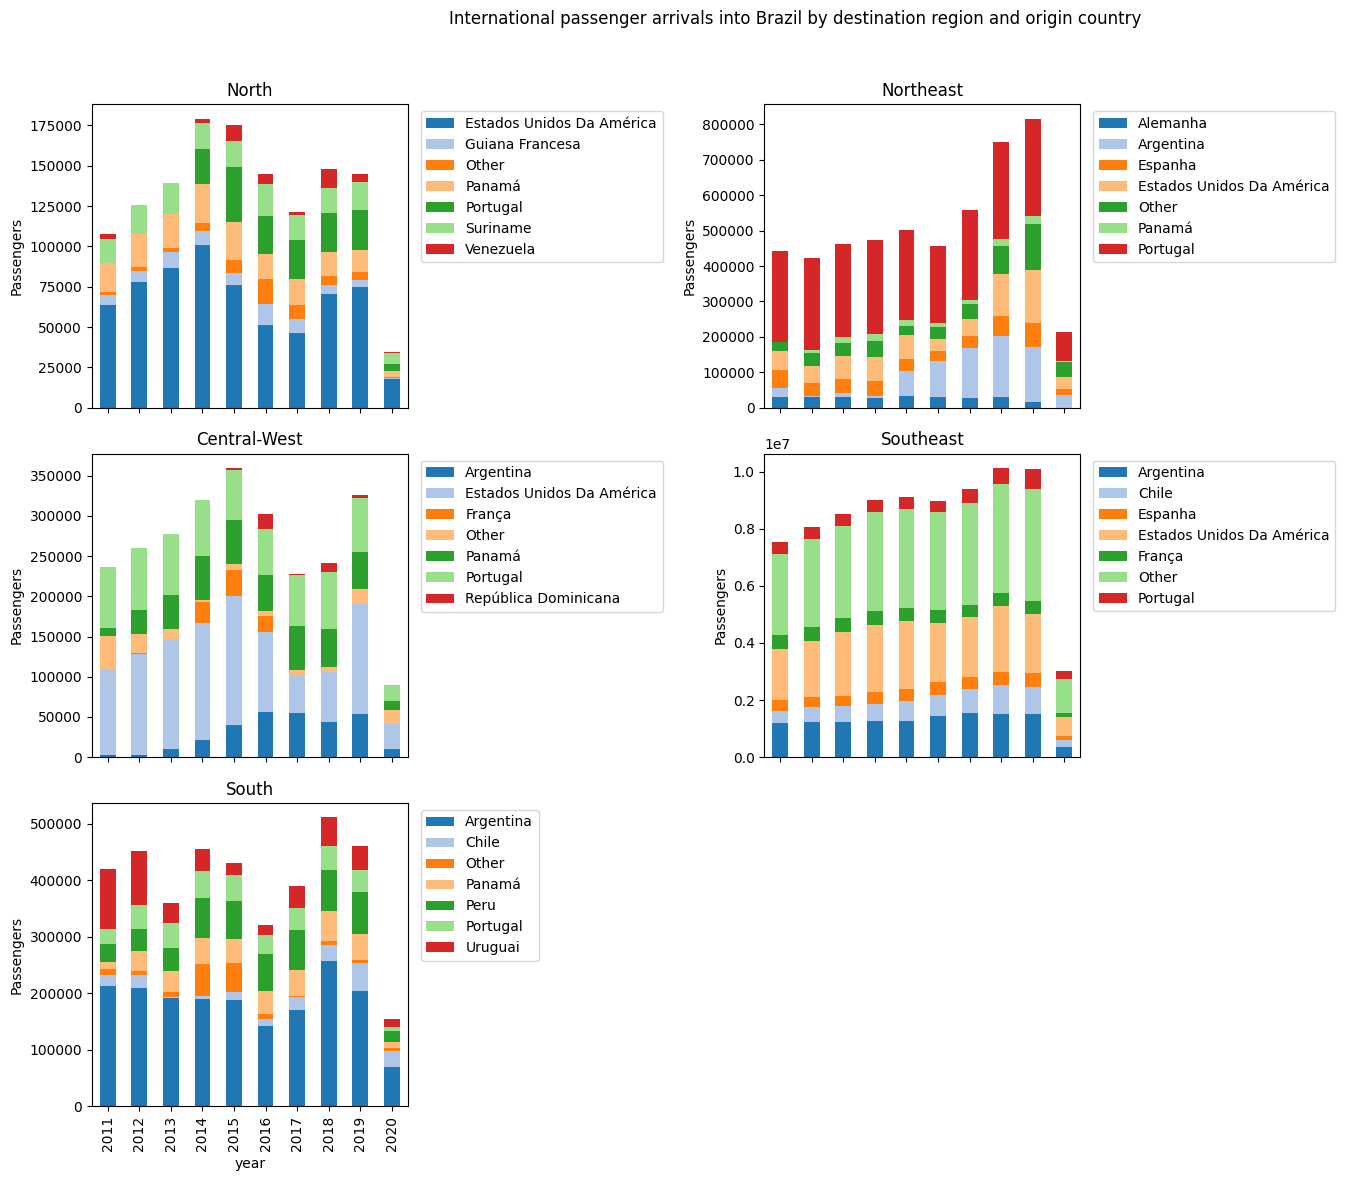

In [9]:

plot_df = df.copy()
region_country_totals = plot_df.groupby(['destination_region', 'origin_country'], as_index=False)['passengers_total'].sum()
region_top_countries = (
    region_country_totals.sort_values(['destination_region', 'passengers_total'], ascending=[True, False])
    .groupby('destination_region')
    .head(MAX_COUNTRIES_PER_REGION)
)
allowed_countries = {region: set(group['origin_country']) for region, group in region_top_countries.groupby('destination_region')}

plot_df['origin_country_grouped'] = plot_df.apply(
    lambda row: row['origin_country'] if row['origin_country'] in allowed_countries.get(row['destination_region'], set()) else 'Other',
    axis=1,
)

yearly_totals = plot_df.groupby(['year', 'destination_region', 'origin_country_grouped'], as_index=False)['passengers_total'].sum()
yearly_totals.to_csv(yearly_path, index=False)
print(f'Saved yearly totals to {yearly_path}')

display(yearly_totals.head())

regions_order = ['North', 'Northeast', 'Central-West', 'Southeast', 'South']
fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for idx, region in enumerate(regions_order):
    ax = axes[idx]
    region_slice = yearly_totals[yearly_totals['destination_region'] == region]
    if region_slice.empty:
        ax.set_visible(False)
        continue
    pivot = region_slice.pivot(index='year', columns='origin_country_grouped', values='passengers_total').fillna(0)
    pivot.sort_index(inplace=True)
    countries = list(pivot.columns)
    color_cycle = [plt.get_cmap('tab20')(i % 20) for i in range(len(countries))]
    pivot.plot(kind='bar', stacked=True, ax=ax, color=color_cycle)
    ax.set_title(region)
    ax.set_ylabel('Passengers')
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))

for j in range(len(regions_order), len(axes)):
    axes[j].set_visible(False)

fig.suptitle('International passenger arrivals into Brazil by destination region and origin country')
fig.tight_layout(rect=[0, 0, 0.85, 0.96])
figure_path = FIGURES_DIR / 'international_arrivals_by_region.png'
fig.savefig(figure_path, dpi=300)
print(f'Saved figure to {figure_path}')
plt.show()



## Next steps

- Push the processed CSVs, report, and figure so collaborators can use them without
  downloading the raw 160 MB JSON.
- When the 2000–2020 archives become available locally, point `DATA_ARCHIVE_PATH` at the
  new tarball and widen the `START_YEAR`/`END_YEAR` window to regenerate the full
  2005–2025 series.
